# Facial recognition via transfer learning
One of the common uses for AI is facial recognition. Transfer learning used with CNNs trained on the ImageNet dataset can do a credible job of recognizing faces in images, but state-of-the-art facial recognition can be achieved by combining transfer learning with CNNs trained with millions of facial images. Fortunately, a handful of such pretrained CNNs exist and are available in the public domain. Let's use Keras to train a pair of facial recognition models — one that uses ResNet50 initialized with ImageNet weights, and another that uses ResNet50 initialized with weights optimized for facial recognition — and see just how accurate CNN-based facial recognition can be. We'll use the Labeled Faces in the Wild dataset to train and validate the networks.

## Load the dataset
The first step is to import facial images from the dataset. LFW contains more than 13,000 facial images collected from the Web. Of the more than 5,000 people represented in the dataset, 1,680 have two or more facial images, while only five have 100 or more. We'll set the minimum number of faces per person to 100, which means that five sets of faces corresponding to five famous people will be imported. Each facial image is labeled with the name of the person that the face belongs to.

Unlike in previous examples in which we loaded 47x62 grayscale images from the LFW dataset, this time we will load 128x128 color images. CNNs work better with images that have equal widths and heights, and pretrained CNNs such as ResNet50 are designed to work with 3-channel color images.

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person=100, resize=1.0, slice_=(slice(60, 188), slice(60, 188)), color=True)
class_count = len(faces.target_names)

print(faces.target_names)
print(faces.images.shape)

['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']
(1140, 128, 128, 3)


Use the following code to show the first several images in the dataset and the people to whom the faces belong.

In [2]:
faces

{'data': array([[0.41568628, 0.3882353 , 0.3254902 , ..., 0.36078432, 0.36862746,
         0.17254902],
        [0.46666667, 0.5411765 , 0.6666667 , ..., 0.20784314, 0.18431373,
         0.13725491],
        [0.14509805, 0.14509805, 0.05098039, ..., 0.4       , 0.20392157,
         0.2       ],
        ...,
        [0.9882353 , 0.99607843, 0.99215686, ..., 0.0627451 , 0.09019608,
         0.15294118],
        [0.4627451 , 0.39607844, 0.29411766, ..., 0.37254903, 0.5019608 ,
         0.5686275 ],
        [0.01176471, 0.01960784, 0.01568628, ..., 0.04313726, 0.03529412,
         0.03921569]], dtype=float32),
 'images': array([[[[0.41568628, 0.3882353 , 0.3254902 ],
          [0.41960785, 0.38431373, 0.3254902 ],
          [0.41568628, 0.38039216, 0.32156864],
          ...,
          [0.34117648, 0.29411766, 0.23921569],
          [0.34509805, 0.29803923, 0.24313726],
          [0.34901962, 0.3137255 , 0.25490198]],
 
         [[0.4117647 , 0.38431373, 0.32156864],
          [0.40784314,

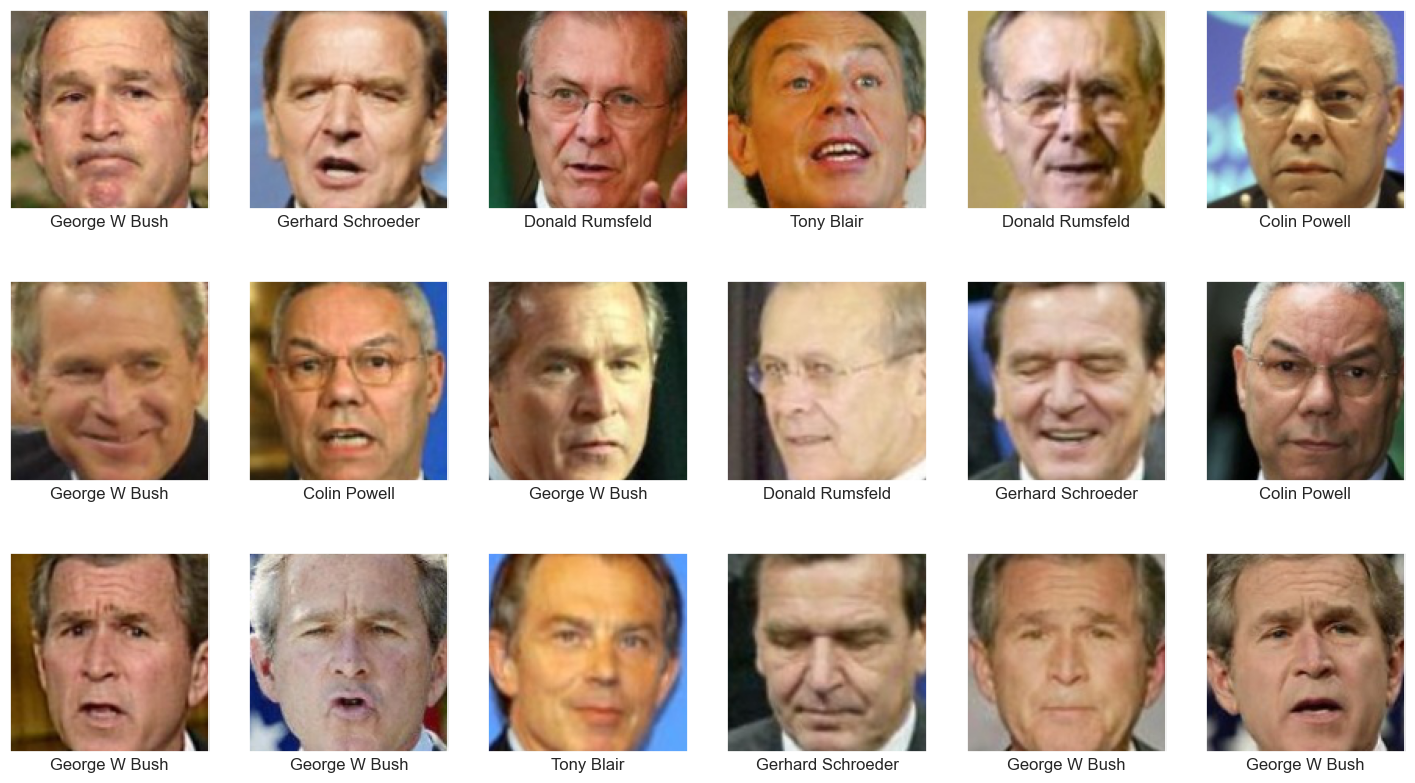

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

fig, ax = plt.subplots(3, 6, figsize=(18, 10))

for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i]) # Scale pixel values so Matplotlib doesn't clip everything above 1.0
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

Check the balance in the dataset by generating a histogram showing how many facial images were imported for each of the five persons, or classes, that the CNN will try to predict.

<Axes: >

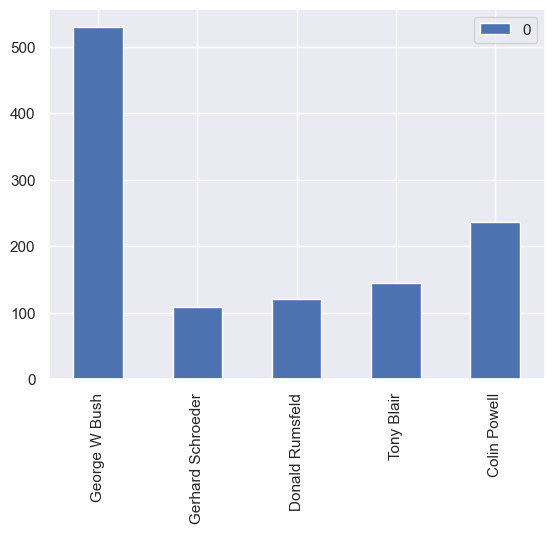

In [4]:
from collections import Counter
counts = Counter(faces.target)
names = {}

for key in counts.keys():
    names[faces.target_names[key]] = counts[key]

df = pd.DataFrame.from_dict(names, orient='index')
df.plot(kind='bar')

Classification models are best trained with balanced datasets. Use the following code to build a dataset containing 100 images of each person.

In [5]:
mask = np.zeros(faces.target.shape, dtype= bool)

for target in np.unique(faces.target):
    mask[np.where(faces.target == target)[0][:100]] = 1

x_faces = faces.data[mask]
y_faces = faces.target[mask]
x_faces = np.reshape(x_faces, (x_faces.shape[0], faces.images.shape[1], faces.images.shape[2], faces.images.shape[3]))
x_faces.shape

(500, 128, 128, 3)

The next step is to preprocess pixel values the way ResNet50 expects and convert the target values (the 0-based indices identifying the person that belongs to a face) into categorical values by one-hot-encoding them. Then split the data for training and testing.

In [6]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split

face_images = preprocess_input(np.array(x_faces))
face_labels = to_categorical(y_faces)

x_train, x_test, y_train, y_test = train_test_split(face_images, face_labels, train_size=0.8, stratify=face_labels, random_state=0)

## Use transfer learning with ResNet50 and ImageNet weights
The first model we'll build employs transfer learning with ResNet50 intialized with the weights computed when the network was trained on more than 1 million images from the ImageNet dataset. Start by loading ResNet50 without the classification layers and freezing the bottleneck layers.

In [7]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False)
base_model.trainable = False

Now add classification layers to the base model and include a Resizing layer to resize images input to the network to 224x224.

In [8]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Resizing

model = Sequential()
model.add(Resizing(224, 224))
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
#Call fit to train the model
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=10, epochs=10)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 46s 811ms/step - accuracy: 0.1530 - loss: 22.4430 - val_accuracy: 0.2100 - val_loss: 3.0876
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 747ms/step - accuracy: 0.2408 - loss: 3.2369 - val_accuracy: 0.2200 - val_loss: 3.2938
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 757ms/step - accuracy: 0.3339 - loss: 2.2523 - val_accuracy: 0.2800 - val_loss: 2.9529
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 764ms/step - accuracy: 0.4339 - loss: 1.9651 - val_accuracy: 0.3200 - val_loss: 2.3168
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 775ms/step - accuracy: 0.2958 - loss: 1.8847 - val_accuracy: 0.4400 - val_loss: 1.3106
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 759ms/step - accuracy: 0.3993 - loss: 1.6172 - val_accuracy: 0.4400 - val_loss: 1.3680
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 735ms/step - accuracy: 0.3647 - loss: 1.4822 - val_accuracy: 0.3600 - val_loss: 2.2023
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 793ms/step - accuracy: 0.3628 - loss: 1.6588 - val_acc

[]

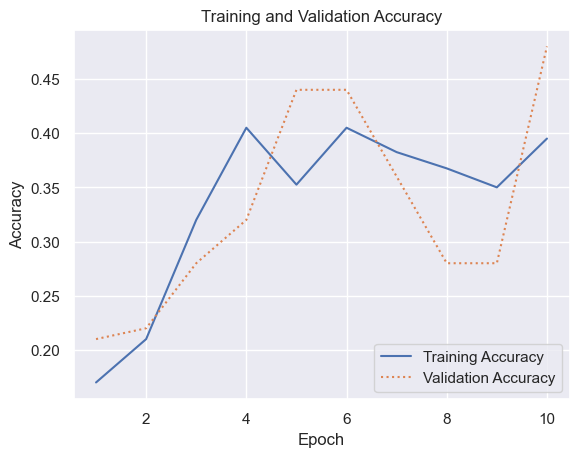

In [10]:
#Plot the training and validation accuracy to see how well the network performed.

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step  


Text(110.44999999999996, 0.5, 'Actual label')

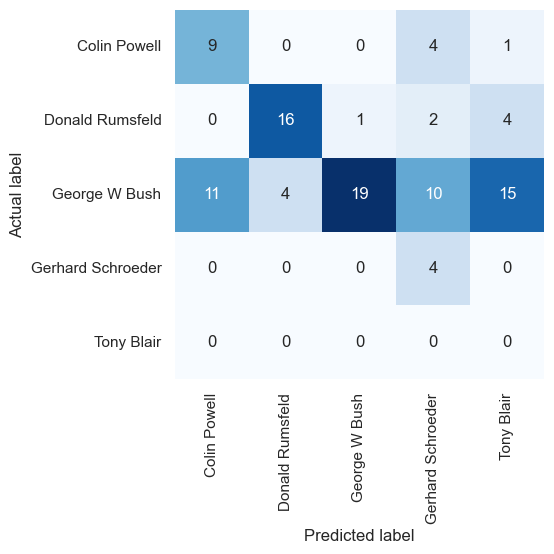

In [11]:
#Run some test data through the network and use a confusion matrix to see how it fared.


from sklearn.metrics import confusion_matrix

y_predicted = model.predict(x_test)
mat = confusion_matrix(y_test.argmax(axis=1), y_predicted.argmax(axis=1))

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

How many times did the network correctly identify George W. Bush? How many times did it fail to identify him?

## Use transfer learning with ResNet50 and VGGFace2 weights
Initialized with ImageNet weights, ResNet50 achieves about 90% accuracy recognizing faces in the LFW dataset. But the ImageNet weights were generated by training the network with images of hundreds of different objects ranging from butterflies to basketballs. These weights are not optimized for extracting features from faces.

keras-vggface is a Python package that models pretrained CNNs trained to recognize the faces of famous people. These CNNs (and their weights) are encapsulated in a class named VGGFace. Let's load the bottleneck layers of the ResNet50 version of VGGFace along with the weights arrived at when it was trained with more than 3 million images in the VGGFace2 dataset and use transfer learning to train the resulting network on the LFW dataset. Begin by loading VGGFace without the classification layers and freezing the bottleneck layers.

In [12]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False)
base_model.trainable = False

Now add classification layers to the base model and include a Resizing layer to resize images input to the network to 224x224.

In [13]:
model = Sequential()
model.add(Resizing(224, 224))
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
#Call fit to train the model.
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=10, epochs=10)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 44s 825ms/step - accuracy: 0.1835 - loss: 20.6652 - val_accuracy: 0.2000 - val_loss: 1.7585
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 747ms/step - accuracy: 0.2379 - loss: 1.9192 - val_accuracy: 0.2200 - val_loss: 2.0029
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 730ms/step - accuracy: 0.2429 - loss: 2.3200 - val_accuracy: 0.3000 - val_loss: 1.5672
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 747ms/step - accuracy: 0.2366 - loss: 1.8994 - val_accuracy: 0.2200 - val_loss: 1.7920
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 734ms/step - accuracy: 0.2588 - loss: 1.7039 - val_accuracy: 0.2000 - val_loss: 1.6981
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 740ms/step - accuracy: 0.2400 - loss: 1.6020 - val_accuracy: 0.2000 - val_loss: 1.5961
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 733ms/step - accuracy: 0.2602 - loss: 1.5993 - val_accuracy: 0.2000 - val_loss: 1.5776
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 734ms/step - accuracy: 0.2179 - loss: 1.5797 - val_acc

[]

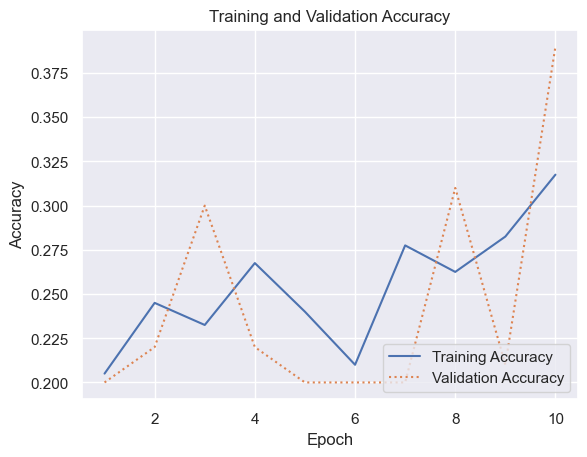

In [15]:
#Plot the training and validation accuracy to see how well the network performed.

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step  


Text(110.44999999999996, 0.5, 'Actual label')

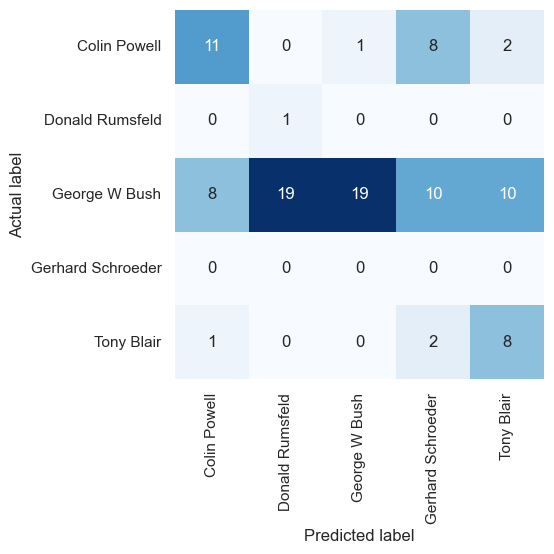

In [16]:
#Run some test data through the network and use a confusion matrix to see how it fared.
y_predicted = model.predict(x_test)
mat = confusion_matrix(y_test.argmax(axis=1), y_predicted.argmax(axis=1))

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

Loaded with weights optimized for extracting features from faces, ResNet50 is much better at recognizing faces than the same network initialized with ImageNet weights. One of the lessons here is that transfer learning using task-specific weights is typically better than transfer learning using generic weights.

## Make a prediction
Load a picture of George W. Bush downloaded from the Internet that has been cropped to 128x128 and use it to make a prediction. The first step is to load the image.

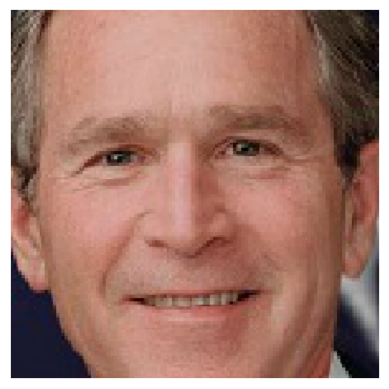

In [17]:
from keras.preprocessing import image

x = image.load_img('george.jpg', target_size=(224, 224))
plt.xticks([])
plt.yticks([])
plt.imshow(x)

In [18]:
#Now see if the network can identify the person in the picture.
x = image.img_to_array(x)
x = np.expand_dims(x, axis=0)
y = model.predict(x)[0]

for i in range(len(y)):
    print(faces.target_names[i] + ': ' + str(y[i]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Colin Powell: 0.060367703
Donald Rumsfeld: 0.27678302
George W Bush: 0.1100466
Gerhard Schroeder: 0.088179074
Tony Blair: 0.4646236
